In [17]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [18]:
import equations as eq
reload (eq);
motion_folder = 'Abduction'
motion_name = 'abduction.mat'
struct_name = 'results_euler_EulInit.mat'

model_struct = sc.io.loadmat('../Motions/'+motion_folder+'/OS_model.mat')
data_struct = sc.io.loadmat('../data_model.mat')
initPos = 'InitPosOptEul'
start = tm.time()
MM,FO,TE,TE_conoid,q,u,fr,frstar,kindeq,xdot,activations = eq.create_eoms_eul(model_struct,data_struct,initPos,derive = 'numeric',gen_matlab_functions = 0)
time_to_create = tm.time() - start
print(time_to_create)

TE created
equations created
512.5958027839661


In [19]:
import equations as eq
reload (eq);
dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondEul'].item()
x0t = list(x0.T[0])

In [20]:
eoms_implicit = sp.Matrix(kindeq).col_join(fr+frstar+TE)

In [21]:
import trajectory_lib as tr
reload (tr);
num_nodes = 101
file = '../Motions/' + motion_folder + '/' + motion_name
traj, interval_value, time = tr.exp_trajectory_eul(file,num_nodes)

state_symbols = tuple(q+u)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [22]:
traj_w = 250
vel_w = 0.1
act_w = 1

def obj(free):
    min_traj = traj_w * interval_value * np.sum((traj - free[:10*num_nodes])**2)
    min_vel = vel_w * interval_value * np.sum((free[10*num_nodes:num_states*num_nodes])**2)
    min_torque = act_w * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:10*num_nodes] = traj_w * 2.0 * interval_value * (free[:10*num_nodes] - traj)
    grad[10*num_nodes:num_states*num_nodes] = vel_w * 2 * interval_value * free[10*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = act_w * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [23]:
instance_constraints = []
# for i in range(9):
#     instance_constraints.append(state_symbols[i].func(0.0)-x0t[i])

instance_constraints.append(state_symbols[-1].func(0.0)-0)

bounds1 = (0.0,1.0)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [24]:
start = tm.time()

prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint'
) #               
time_to_create = tm.time() - start
print(time_to_create)

1207.368369102478


In [25]:
prob.add_option('max_iter',2500)
# prob.add_option('limited_memory_max_history', 40)

In [26]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:10*num_nodes] = traj

In [27]:
time_2_solve_start = tm.time()
solution, info = prob.solve(initial_guess)
time_2_solve = tm.time() - time_2_solve_start
print(info['status_msg'])
print(info['obj_val'])
act_obj = np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)


print('Objective activations: ', act_obj)

b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to "acceptable" tolerances (see the acceptable-... options).'
3.989911105553258
Objective activations:  94.41324318735948


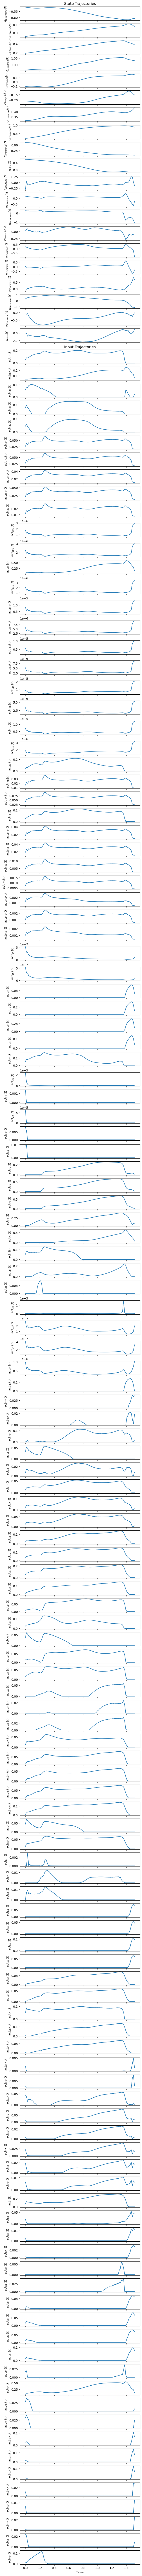

In [28]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

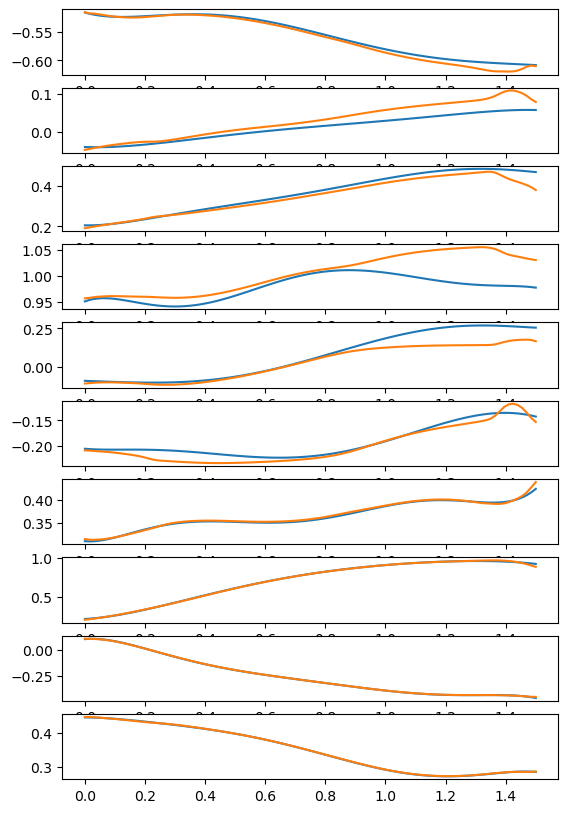

In [29]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(10)
for j in range(10):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

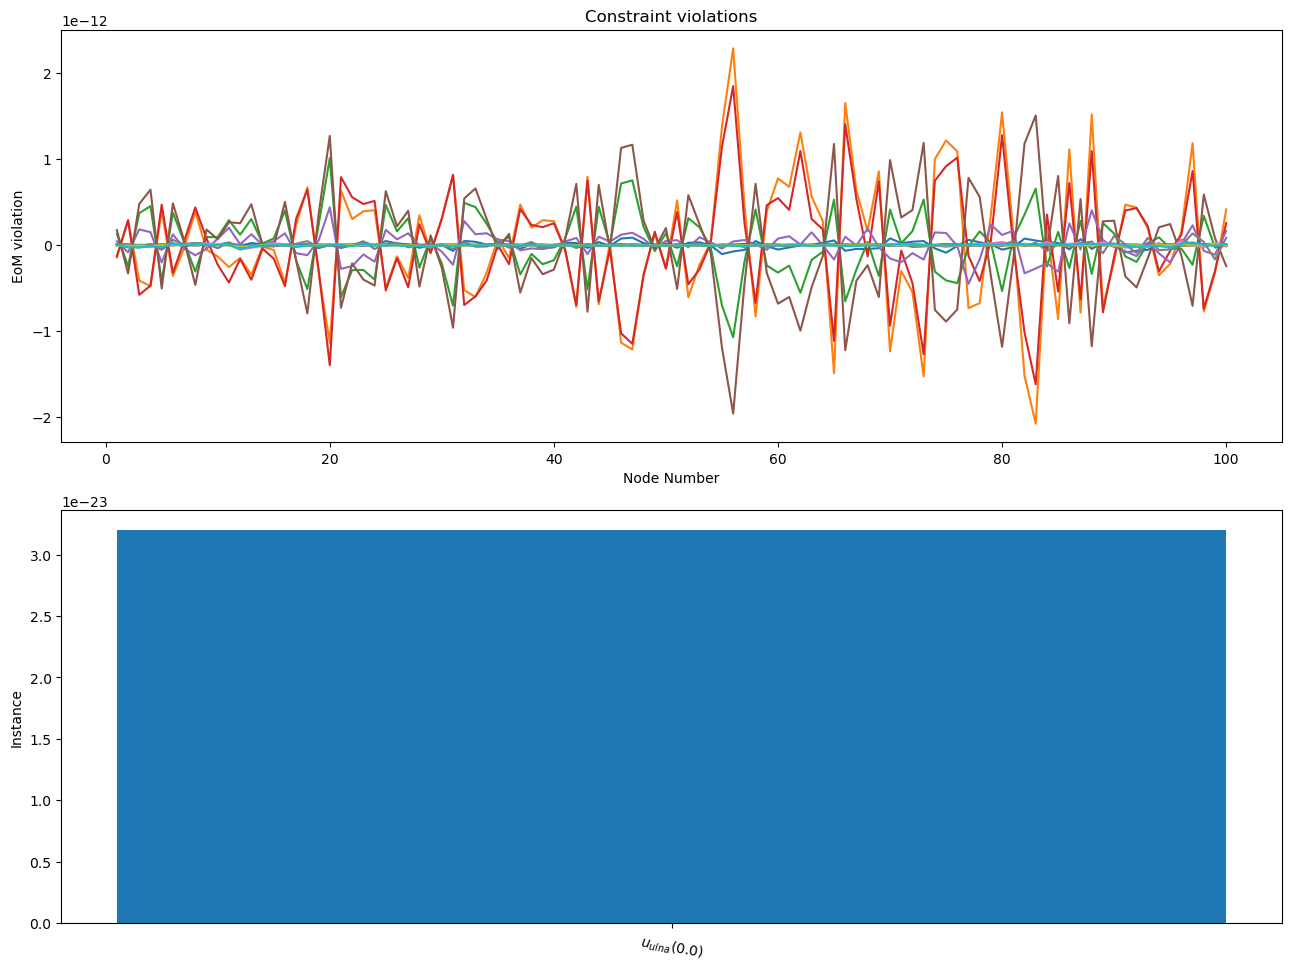

In [30]:
fig, axes = plt.subplots(2, figsize=(12.8, 9.6),
                         layout='constrained')
prob.plot_constraint_violations(solution, axes=axes)

In [31]:
import trajectory_lib as tr
reload (tr);
file_name = '../Motions/'+motion_folder+'/' + struct_name
tr.sol2struct(solution,activations,len(q),num_states,num_nodes,time,time_2_solve,file_name)

Saved to .mat file
